In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv('adult.csv')

In [ ]:
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

In [ ]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
print(f"Baseline RF Accuracy: {accuracy_score(y_test, rf_base.predict(X_test)):.4f}")

Baseline RF Accuracy: 0.8485


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, 30, None],      # Max depth of each tree
    'min_samples_split': [2, 5, 10],      # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],        # Min samples at a leaf node
    'bootstrap': [True, False]            # Method of selecting samples for training
}

In [ ]:
print("\nTuning Random Forest (this may take a minute)...")
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,        # Number of parameter settings sampled
    cv=3,             # 3-fold cross-validation
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)


Tuning Random Forest (this may take a minute)...


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42)

In [ ]:
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n--- Optimized Random Forest Results ---")
print(f"Best Parameters: {rf_random.best_params_}")
print(f"Tuned Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Optimized Random Forest Results ---
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
Tuned Accuracy: 0.8589

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4533
           1       0.77      0.62      0.69      1500

    accuracy                           0.86      6033
   macro avg       0.82      0.78      0.80      6033
weighted avg       0.85      0.86      0.85      6033



/tmp/ipython-input-481936373.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


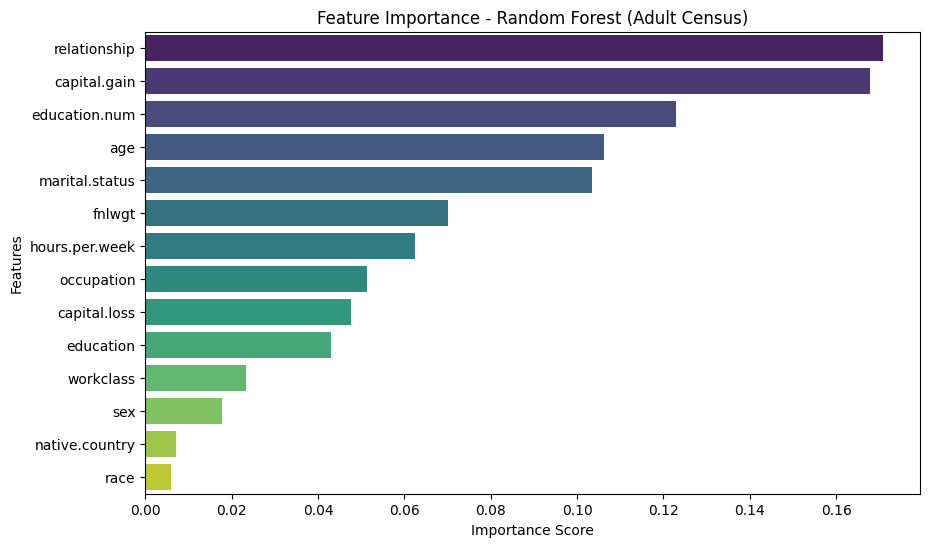

In [ ]:
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest (Adult Census)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

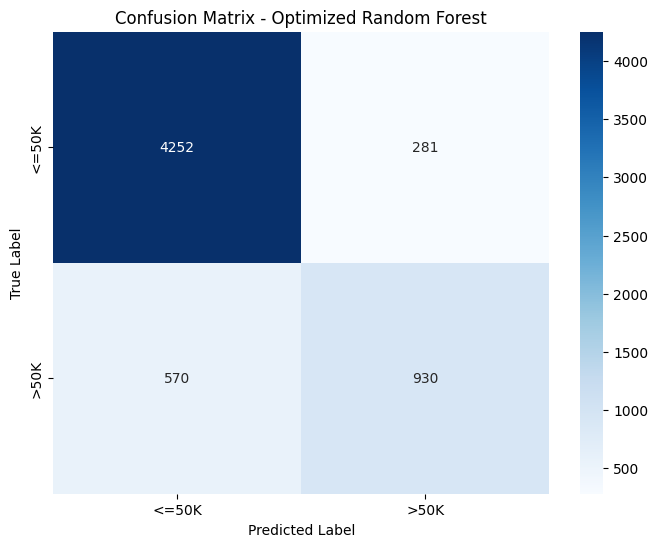

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()